In [3]:
from datetime import datetime
import geopandas as gpd
import numpy as np
import pandas as pd

In [6]:
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}

# Load the data

In [5]:
## Read csvs
train_df = gpd.read_file('train.geojson', index_col=0)
test_df = gpd.read_file('test.geojson', index_col=0)

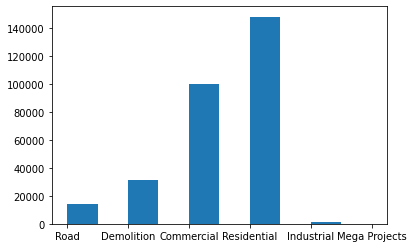

In [7]:
from matplotlib import pyplot as plt
plt.hist(train_df['change_type'])
plt.show()


In [8]:
def Convert_date(x):
    if pd.isna(x):
        return pd.NaT
    try:
        return datetime.strptime(str(x), '%d-%m-%Y').date()
    except (ValueError, TypeError):
        return pd.NaT

In [48]:
def Format_data(df : gpd.GeoDataFrame) -> pd.DataFrame :
    """fomrmat the geopandas dataframe to a correct dataframe with one hoit encoded columns and normalized values

    Args:
        df (gpd.GeoDataFrame): The geopandas dataframe to format

    Returns:
        pd.DataFrame: The correct formated dataframe
    """
    #Convert urban types and geography types to one hot by hand, because mixed values are possible
    urban_types = df['urban_type'].str.split(',', expand = True)
    geography_types = df['geography_type'].str.split(',', expand = True)

    unique_urban_types = set(urban_types.values.flatten()) - {None}
    unique_geography_types = set(geography_types.values.flatten()) - {None}
    one_hot_encoded = pd.DataFrame(index=df.index)

    for urban_type in unique_urban_types:
        one_hot_encoded[urban_type] = urban_types.apply(lambda row: 1 if urban_type in row.values else 0, axis=1)

    for geography_type in unique_geography_types:
        one_hot_encoded[geography_type] = geography_types.apply(lambda row: 1 if geography_type in row.values else 0, axis=1)
    
    df_oh = pd.concat([df, one_hot_encoded], axis=1)
    df_oh = df_oh.drop(['urban_type', 'geography_type'], axis = 1)

    #one hot encode other categorical columns
    df_oh = pd.get_dummies(df_oh,columns=['change_status_date0',
    'change_status_date1', 'change_status_date2', 'change_status_date3',
    'change_status_date4'])

    #convert the geometry in intersting features
    df_oh.loc[:,'area'] = df_oh[['geometry']].area
    df_oh.loc[:,'length'] = df_oh[['geometry']].length

    df_oh = df_oh.drop(['N', 'A', 'geometry', 'index'], axis = 1)

    return df_oh

In [11]:
def Normalize(df_oh, columns) :
    df_oh.loc[:,columns] = (df_oh.loc[:,columns] - df_oh.loc[:,columns].mean())/(df_oh.loc[:,columns].std())
    return df_oh

In [49]:
train_df_oh, test_df_oh = Format_data(train_df), Format_data(test_df)

C:\Users\emili\AppData\Local\Temp\ipykernel_20432\1981067603.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_oh.loc[:,'area'] = df_oh[['geometry']].area
C:\Users\emili\AppData\Local\Temp\ipykernel_20432\1981067603.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_oh.loc[:,'length'] = df_oh[['geometry']].length
C:\Users\emili\AppData\Local\Temp\ipykernel_20432\1981067603.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_oh.loc[:,'area'] = df_oh[['geometry']].area
C:\Users\emili\AppData\Local\Temp\ipykernel_20432\1981067603.py:34: UserWarning: Geometry is in a ge

In [50]:
def Set_dif_date_columns(df) :
    df = df.fillna(0)
    df.loc[:,'date0'] = pd.to_datetime(df['date0'].apply(Convert_date))
    df.loc[:,'date1'] = pd.to_datetime(df['date1'].apply(Convert_date))
    df.loc[:,'date2'] = pd.to_datetime(df['date2'].apply(Convert_date))
    df.loc[:,'date3'] = pd.to_datetime(df['date3'].apply(Convert_date))
    df.loc[:,'date4'] = pd.to_datetime(df['date4'].apply(Convert_date))

    dif1 = []
    dif2 = []
    dif3 = []
    dif4 = []

    for _,dates in df.loc[:,['date0', 'date1', 'date2', 'date3', 'date4']].iterrows():
        dif1.append((dates['date1'] - dates['date0']).days)
        dif2.append((dates['date2'] - dates['date1']).days)
        dif3.append((dates['date3'] - dates['date2']).days)
        dif4.append((dates['date4'] - dates['date3']).days)
    
    df.loc[:,'date_dif1'] = dif1
    df.loc[:,'date_dif2'] = dif2
    df.loc[:,'date_dif3'] = dif3   
    df.loc[:,'date_dif4'] = dif4  
    df = df.fillna(0)
    df = df.drop(['date0', 'date1', 'date2', 'date3','date4'], axis = 1)

    return df


In [51]:
train, test = Set_dif_date_columns(train_df_oh), Set_dif_date_columns(test_df_oh)

# Outlier study

In [65]:
from matplotlib import pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay

[]

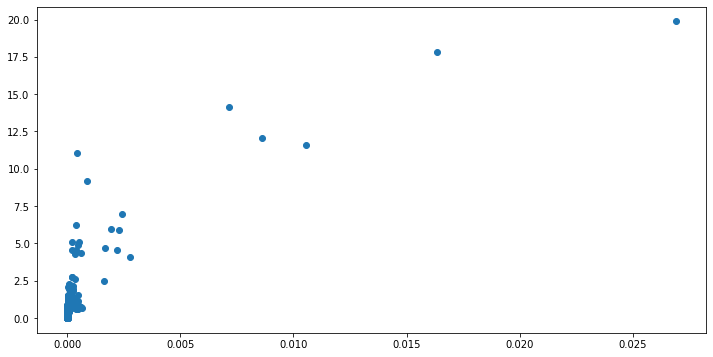

In [78]:
plt.scatter(train['area'], train['length'])
plt.plot()

In [152]:
clf = IsolationForest(max_samples = 1000)

In [ ]:
y = clf.fit_predict(train_df_oh.loc[:,['area','length']])
print(len(train_df_oh.loc[np.where(y == -1)[0], 'length']))
plt.figure(figsize = (20,20))

plt.scatter(train_df_oh.loc[np.where(y == -1)[0], 'area'],train_df_oh.loc[np.where(y == -1)[0], 'length'], c = 'r', label = 'outlier')
plt.scatter(train_df_oh.loc[np.where(y != -1)[0], 'area'],train_df_oh.loc[np.where(y != -1)[0], 'length'], c = 'b', label = 'inlier')
plt.legend()
plt.show()



In [155]:
train_df_oh_reduced = train_df_oh.loc[np.where(y != -1)[0]]

In [ ]:
plt.scatter(train_df_oh_reduced['length'],train_df_oh_reduced['area'], c = train_df_oh_reduced['change_type'].apply(lambda x: change_type_map[x]))
plt.show()

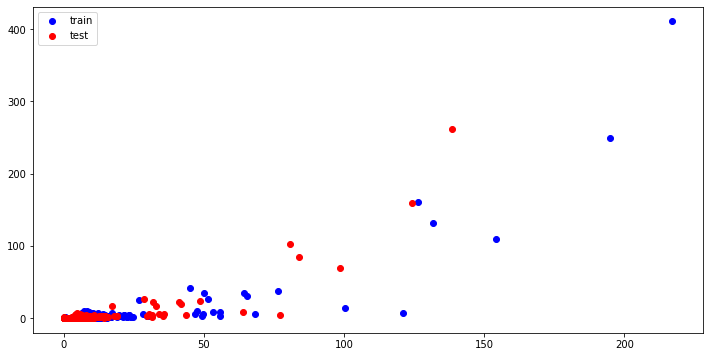

In [420]:
plt.scatter(train_df_oh['length'],train_df_oh['area'], c = 'b', label = 'train')
plt.legend()
plt.show()

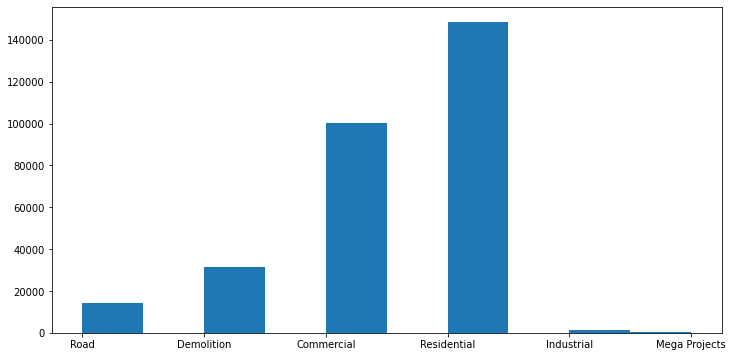

In [421]:
plt.hist(train_df_oh['change_type'])
plt.show()

In [159]:
print(test_df_oh.shape)
train_df_oh = train_df_oh.dropna(axis = 0)
test_df_oh = test_df_oh.dropna(axis = 0)
print(test_df_oh.shape)

(120526, 107)
(120526, 107)


# Other feature formating

In [ ]:
from sklearn.utils import shuffle

In [52]:
train.loc[:,'change_type'] = train['change_type'].apply(lambda x: change_type_map[x])

Big inequalities in the number of samaples in the classes -> The accuracy of the models will be mainly bounded by the ratios of classes 2 and 3.
We will take only the number of samples of the class 1 (around 7000 samples), and drop the class 4 and five because their aren't enough examples of thoses classes

In [53]:
def Balance_data_set(df, keepMinorities = True) -> pd.DataFrame:
    if keepMinorities :
        classes_to_keep = [0,1,2,3,4,5]
        
    else :
        classes_to_keep = [0,1,2,3]

    df = df.loc[df['change_type'].isin(classes_to_keep)] #we keep classes 0 to 3
    numb_per_class = len(df.loc[df['change_type'] == 1])
    df_balanced = pd.DataFrame()
    for i in classes_to_keep :
        df_class = df.loc[df['change_type'] == i]
        df_class = df_class.sample(n=min(numb_per_class, len(df_class)))
        df_balanced = pd.concat([df_balanced,df_class])

    df_balanced = shuffle(df_balanced).reset_index()
    df_balanced = df_balanced.drop(['index'], axis = 1)

    return df_balanced


In [54]:
train_balanced = Balance_data_set(train)

In [55]:
features_to_drop = ['Snow', 'length', 'area']

In [56]:
train_balanced = train_balanced.drop(features_to_drop, axis = 1)
test = test.drop(features_to_drop, axis = 1)

In [57]:
columns_to_normalize = ['img_red_mean_date1', 'img_green_mean_date1',
       'img_blue_mean_date1', 'img_red_std_date1', 'img_green_std_date1',
       'img_blue_std_date1', 'img_red_mean_date2', 'img_green_mean_date2',
       'img_blue_mean_date2', 'img_red_std_date2', 'img_green_std_date2',
       'img_blue_std_date2', 'img_red_mean_date3', 'img_green_mean_date3',
       'img_blue_mean_date3', 'img_red_std_date3', 'img_green_std_date3',
       'img_blue_std_date3', 'img_red_mean_date4', 'img_green_mean_date4',
       'img_blue_mean_date4', 'img_red_std_date4', 'img_green_std_date4',
       'img_blue_std_date4', 'img_red_mean_date5', 'img_green_mean_date5',
       'img_blue_mean_date5', 'img_red_std_date5', 'img_green_std_date5',
       'img_blue_std_date5',  'date_dif1', 'date_dif2',
       'date_dif3', 'date_dif4']

In [60]:
norm_train_balanced = Normalize(train_balanced,columns_to_normalize)
norm_test = Normalize(test,columns_to_normalize)

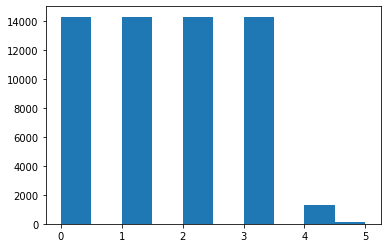

(58695, 100)


In [28]:
plt.hist(norm_train_balanced['change_type'])
plt.show()
print(norm_train_balanced.shape)

# Feature analysis

## Dimensionality reduction : PCA

In [29]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

In [30]:
N_COMP = norm_train_balanced.shape[1]

In [31]:
pca = PCA(n_components = N_COMP)
pca.fit(norm_train_balanced)

PCA(n_components=100)

[0.24874013 0.40001409 0.47469847 0.52328839 0.56959136 0.61143606
 0.64660892 0.6804607  0.7116884  0.74100974 0.76861819 0.79519148
 0.81942077 0.83412652 0.84744452 0.85713503 0.86493334 0.87258319
 0.87953918 0.8860247  0.89220753 0.89820852 0.90343696 0.90839273
 0.91310711 0.91771289 0.92205274 0.9263634  0.93058394 0.9342293
 0.93749546 0.94062368 0.94365391 0.94649017 0.94923223 0.95185664
 0.95430413 0.95671373 0.9590302  0.96121048 0.96330702 0.96539467
 0.96740433 0.96935436 0.97121901 0.97301951 0.97469806 0.97625571
 0.97775164 0.97915999 0.98046631 0.98170049 0.98292663 0.98403159
 0.98511138 0.98615964 0.98715262 0.98806865 0.98890891 0.98961033
 0.99017495 0.99072338 0.99123992 0.99175204 0.992256   0.99275255
 0.99322502 0.9935993  0.99396813 0.99433613 0.99469698 0.99504986
 0.99539234 0.99573069 0.99605583 0.99637292 0.99666971 0.99696129
 0.99722828 0.9974758  0.99771281 0.99793316 0.99815022 0.99835267
 0.99854362 0.99872975 0.99891206 0.99908753 0.99925468 0.99941

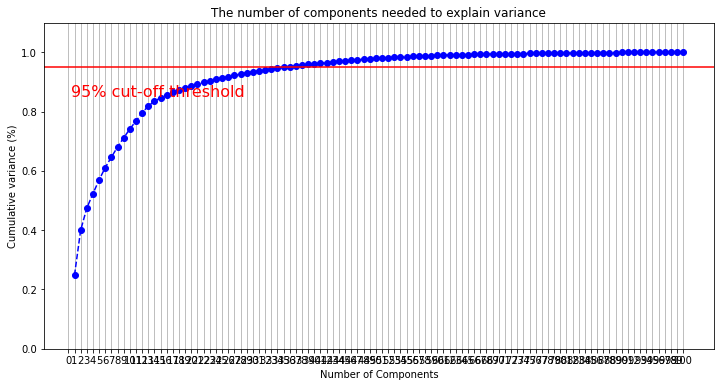

In [32]:

# matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, N_COMP + 1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
print(y)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, N_COMP + 1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [61]:
def Reduce_features(df, pca = None, keepBestFeatures = False, threshold = 0.1) :
    if(keepBestFeatures) :
        corr_matrix = df.corr().abs()
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})

        target_cor_raw = pd.DataFrame(corr_matrix.loc['change_type']).sort_values(by='change_type', axis = 0)
        best_features = target_cor_raw.loc[target_cor_raw['change_type'] > 0.02]
        print(f"The best features kept are: {best_features}")
        df = df.loc[:,best_features.index]
    
    if(pca) :
        df = pca.fit_transform(df)
    
    print(f"Number of features: {df.shape[1]}\n Number of samples: {df.shape[0]}")
    return df   

In [101]:
print(test.shape)

(120526, 99)


The best features kept are:                                         change_type
River                                      0.022032
Desert                                     0.025305
img_red_mean_date2                         0.029512
Dense Urban                                0.031896
Sparse Forest                              0.034426
...                                             ...
change_status_date1_Prior Construction     0.228088
change_status_date3_Prior Construction     0.246143
change_status_date2_Prior Construction     0.250467
change_status_date0_Prior Construction     0.335433
change_type                                1.000000

[86 rows x 1 columns]
Number of features: 86
 Number of samples: 58695


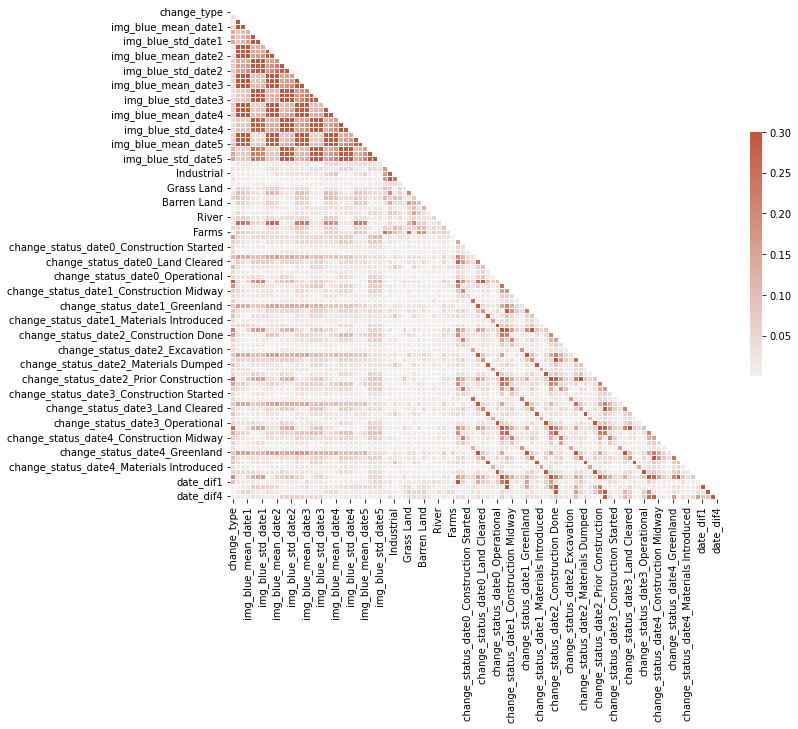

In [64]:
norm_train_reduced = Reduce_features(norm_train_balanced, keepBestFeatures=True)
norm_test_reduced = norm_test.loc[:,norm_train_reduced.drop('change_type', axis = 1).columns]

In [103]:
norm_train_reduced.shape

(58695, 86)

# Data split

In [104]:
train_df_X = norm_train_reduced.drop(['change_type'], axis = 1)
train_df_Y = norm_train_reduced['change_type']

In [105]:
train_X, train_Y = np.asarray(train_df_X, dtype = np.float32), np.asarray(train_df_Y, dtype= np.int32)

In [106]:
#Simple split
#TODO : Implement cross validation for the training and validation

split_ratio = 0.8

train_x, val_x = train_X[:int(len(train_X)*split_ratio)], train_X[int(len(train_X)*split_ratio):]
train_y, val_y = train_Y[:int(len(train_X)*split_ratio)], train_Y[int(len(train_X)*split_ratio):]

In [107]:
print(train_x.shape)
print(val_x.shape)

(46956, 85)
(11739, 85)


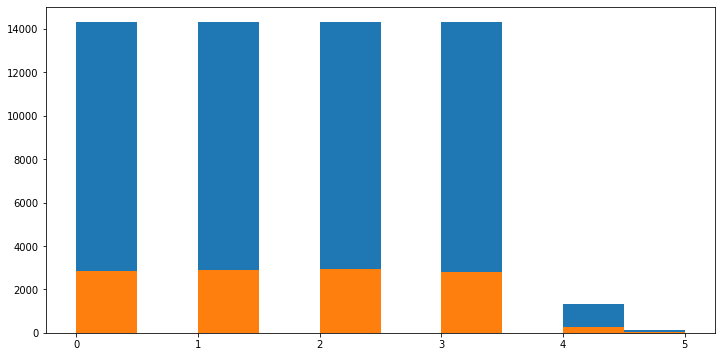

In [69]:
plt.hist(train_Y, label = 'Train')
plt.hist(val_y,label='Validation')
plt.show()

# First model

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from tqdm import tqdm

In [108]:
accuracies = []
for neighbors in tqdm(range(3,31)) : 
    neigh = KNeighborsClassifier(n_neighbors=neighbors)
    neigh.fit(train_x, train_y)
    pred_y = neigh.predict(val_x)
    accuracies.append(accuracy_score(val_y, pred_y))

100%|██████████| 28/28 [00:27<00:00,  1.00it/s]


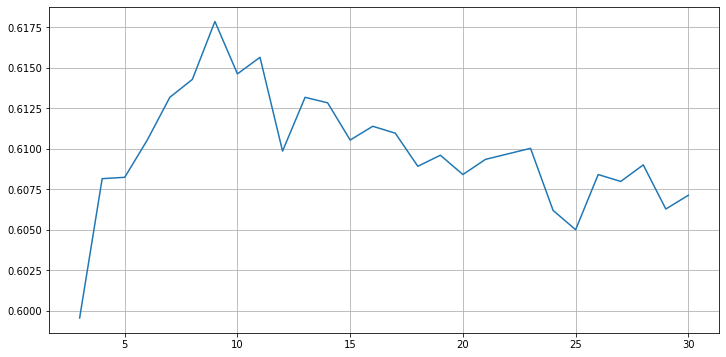

Best accuracie achieved : 0.6178550132038504


In [109]:
plt.plot(range(3,31), accuracies)
plt.grid(True)
plt.show()

print(f"Best accuracie achieved : {max(accuracies)}")


Best accuracy : 0.61

In [110]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(train_x, train_y)
pred_y = neigh.predict(val_x)
# acc= accuracy_score(val_y,pred_y)

In [111]:
print(confusion_matrix(val_y,pred_y))
print(f"Mean f1 score: {f1_score(val_y, pred_y, average = 'micro' )}")

[[2338  137  219  127    2    0]
 [ 181 2205  270  232    1    0]
 [ 253  610 1576  476    3    0]
 [ 304  828  659  996   17    0]
 [  24   65   67   93   27    0]
 [   5    9    8    7    0    0]]
Mean f1 score: 0.6083993525853991


# Second model

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [76]:
decTree = DecisionTreeClassifier()
decTree.fit(train_x, train_y)
pred_y = decTree.predict(val_x)
print(accuracy_score(val_y, pred_y))

0.5730471079308289


# Third model

In [158]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
accuracies = []
randFor = GradientBoostingClassifier()
randFor.fit(train_x, train_y)
pred_y = randFor.predict(val_x)
acc = accuracy_score(val_y, pred_y)
print(acc)
accuracies.append(acc)

Best accuracy : 0.59

# Fourth model

In [356]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
svc = SVC(gamma=2, C=1)
svc.fit(train_x, train_y)
pred_y = svc.predict(val_x)
acc = accuracy_score(val_y, pred_y)
print(acc)


Best accuracy :

# Neural network

In [77]:
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

device = torch.device('cpu')
print(torch.cuda.is_available())

True


In [78]:
class SimpleNN(nn.Module):
    def __init__(self,n_input,n_neurones):
        super(SimpleNN,self).__init__()
        self.layer1 = nn.Linear(n_input,n_neurones)
        self.layer2 = nn.Linear(n_neurones, int(n_neurones/3))
        self.layer3 = nn.Linear(int(n_neurones/3),6)
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [79]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    for x, labels in torch.utils.data.DataLoader(data, batch_size=64):
        x = x.to(device)
        labels = labels.to(device)
        output = model(x)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).cpu().detach().sum().item()
        total += x.cpu().detach().shape[0]
    return correct / total
  


In [81]:
def train(model, train_data, val_data, batch_size=64, num_epochs=1 , print_stat = 1):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
    # criterion = nn.MultiMarginLoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00002)
    # scheduler = lr_scheduler.LinearLR(optimizer,start_factor=1.0, end_factor=0.005, total_iters=num_epochs/2)


    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for x, labels in iter(train_loader):
            x = x.to(device)
            labels = labels.to(device)
            out = model(x)            
            loss = criterion(out, labels)
            
            loss.backward()               
            
            optimizer.step()
                      
            optimizer.zero_grad()         

            # save the current training information
            iters.append(n)
            train_loss = float(loss.cpu().detach())/batch_size
                     
            n += 1
        losses.append(train_loss)    
        train_accu,val_accu = get_accuracy(model, train_data),get_accuracy(model, val_data)
        train_acc.append(train_accu) # compute training accuracy 
        val_acc.append(val_accu)  # compute validation accuracy

        # scheduler.step()
        lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch {epoch}, Train Loss: {train_loss}, Train accuracy: {train_accu}, Validation accuracy: {val_accu}, Learning rate: {lr}")

    if print_stat:
      # plotting
      plt.title("Training Curve")
      plt.plot(range(num_epochs), losses, label="Train")
      plt.xlabel("Iterations")
      plt.ylabel("Loss")
      plt.show()

      plt.title("Training Curve")
      plt.plot(range(num_epochs), train_acc, label="Train")
      plt.plot(range(num_epochs), val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

      print("Final Training Accuracy: {}".format(train_acc[-1]))
      print("Final Validation Accuracy: {}".format(val_acc[-1]))
    
    
    
print('done')

done


In [82]:
split_ratio = 0.8

train_x, val_x = train_X[:int(len(train_X)*split_ratio)], train_X[int(len(train_X)*split_ratio):]
train_y, val_y = train_Y[:int(len(train_X)*split_ratio)], train_Y[int(len(train_X)*split_ratio):]

In [113]:
model = SimpleNN(train_x.shape[1], 90)
model = model.to(device)

In [100]:
train_x.shape
model

SimpleNN(
  (layer1): Linear(in_features=99, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=33, bias=True)
  (layer3): Linear(in_features=33, out_features=6, bias=True)
)

In [114]:
train_x = np.array(train_x, dtype = np.float32)
val_x = np.array(val_x, dtype = np.float32)

In [115]:
X = torch.Tensor(train_x)
Y=torch.Tensor(train_y)
Y = Y.type(torch.LongTensor)
train_data = data_utils.TensorDataset(X,Y)

X_ = torch.Tensor(val_x)
Y_=torch.Tensor(val_y)
Y_ = Y_.type(torch.LongTensor)
val_data = data_utils.TensorDataset(X_,Y_)


In [ ]:
train(model, train_data = train_data, val_data = val_data, num_epochs = 3000, batch_size = 192)

In [117]:
pred_y = []

for x, labels in torch.utils.data.DataLoader(val_data, batch_size=1):
    with torch.no_grad():
        model = model.cpu()
        output = model(x)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        pred_y.append(pred.item())

pred_y = np.array(pred_y)

In [118]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

print(confusion_matrix(val_y,pred_y))
print(f"Mean f1 score: {f1_score(val_y, pred_y, average = 'macro' )}")

[[2543   72   75  130    3    0]
 [  68 2044  335  437    5    0]
 [ 133  413 1691  670   11    0]
 [ 141  536  653 1452   22    0]
 [  18   49   51  114   44    0]
 [   5    7    4   12    1    0]]
Mean f1 score: 0.4863502971260312


# Test and create submission

In [112]:
X = torch.Tensor(np.array(norm_test, dtype=np.float32))
preds = []
for x in X:
    with torch.no_grad():
        model = model.cpu()
        output = model(x)
        #select index with maximum prediction score
        pred = output.max(0, keepdim=True)[1]
        preds.append(pred.item())
submission_df = pd.DataFrame({'change_type': preds})
submission_df.to_csv("nn_submission.csv", index=True, index_label='Id')
